<a href="https://colab.research.google.com/github/Tejasri-111/arista-ml/blob/main/Detect_noise_attempt1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Cell 1: Installations (Updated)
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
!pip install -q torch torchvision torchaudio opencv-python pycocotools matplotlib
!pip install -q git+https://github.com/facebookresearch/segment-anything.git
!pip install -q supervision  # Add supervision for better visualization

print("Setup Complete.")

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.2/207.2 kB 8.5 MB/s eta 0:00:00
Setup Complete.


In [2]:
# Cell 2: Imports
import os
import numpy as np
import cv2
import torch
import json
from scipy import stats
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from datetime import datetime
import shutil
import supervision as sv

print("Setup Complete. All libraries installed and imported.")

Setup Complete. All libraries installed and imported.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Define the path to the zip file in your Google Drive
# Make sure the path matches the location where you saved the file
drive_zip_path = '/content/drive/My Drive/Inter-IIT Tech 14.0/DATASET.zip'

# Define the destination path in the Colab environment
local_zip_path = './DATASET.zip'

# Copy the file from Drive to the local environment
import shutil
if os.path.exists(drive_zip_path):
    print(f"Copying '{drive_zip_path}' to '{local_zip_path}'...")
    shutil.copyfile(drive_zip_path, local_zip_path)
    print("Copy complete.")
else:
    print(f"Error: '{drive_zip_path}' not found in your Google Drive.")
    print("Please ensure the file is in the correct location in your Drive.")

Copying '/content/drive/My Drive/Inter-IIT Tech 14.0/DATASET.zip' to './DATASET.zip'...
Copy complete.


In [5]:
# Cell 3: Load the Dataset from DATASET.zip

import os
import shutil

# --- Instructions ---
# Please ensure you have uploaded 'DATASET.zip' to this environment before running this cell.

zip_filename = "DATASET.zip"
image_dir = 'image_captures'
npy_dir = 'npy_captures'
output_dir = 'filtered_results'

# Clean up previous runs if they exist
if os.path.exists(image_dir):
    shutil.rmtree(image_dir)
if os.path.exists(npy_dir):
    shutil.rmtree(npy_dir)

if os.path.exists(zip_filename):
    print(f"Found '{zip_filename}'. Unzipping data...")
    # Unzip the file. The '-o' flag overwrites existing files without asking.
    # The '-q' flag runs in quiet mode to avoid printing all 400 filenames.
    !unzip -o -q {zip_filename}

    # Verify that the expected directories were created
    if os.path.exists(image_dir) and os.path.exists(npy_dir):
        num_images = len([f for f in os.listdir(image_dir) if f.endswith('.png')])
        num_npy = len([f for f in os.listdir(npy_dir) if f.endswith('.npy')])

        print("Unzipping complete.")
        print(f"Found {num_images} images in '{image_dir}/'")
        print(f"Found {num_npy} .npy files in '{npy_dir}/'")
    else:
        print(f"Error: After unzipping, the expected directories '{image_dir}' and/or '{npy_dir}' were not found.")
        print("Please check the structure of your zip file.")

else:
    print(f"--- IMPORTANT ---")
    print(f"Error: '{zip_filename}' not found.")
    print(f"Please upload your dataset zip file to the session storage and run this cell again.")

# Create the output directory for JSON results, if it doesn't exist
os.makedirs(output_dir, exist_ok=True)
print(f"Output directory '{output_dir}' is ready.")

Found 'DATASET.zip'. Unzipping data...
Unzipping complete.
Found 400 images in 'image_captures/'
Found 25 .npy files in 'npy_samples/'
Output directory 'filtered_results' is ready.


In [6]:
# Cell 4: Initialize SAM with a Tunable Automatic Mask Generator

def initialize_tuned_sam_generator(
    model_type="vit_h",
    checkpoint="sam_vit_h_4b8939.pth",
    # --- Key Tuning Parameters for "Everything" mode ---
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100
):
    """
    Initializes and returns a highly tunable SAM AutomaticMaskGenerator,
    replicating the "Everything" functionality.
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Loading SAM model to {device.upper()}...")

    sam = sam_model_registry[model_type](checkpoint=checkpoint)
    sam.to(device=device)

    mask_generator = SamAutomaticMaskGenerator(
        model=sam,
        points_per_side=points_per_side,
        pred_iou_thresh=pred_iou_thresh,
        stability_score_thresh=stability_score_thresh,
        crop_n_layers=crop_n_layers,
        crop_n_points_downscale_factor=crop_n_points_downscale_factor,
        min_mask_region_area=min_mask_region_area,
    )

    print("Tunable SamAutomaticMaskGenerator initialized successfully.")
    return mask_generator

# We will call this function from our main pipeline in Cell 6
# This allows us to define the parameters there for easy experimentation.

In [9]:
# Cell 5: Advanced Filtering Logic with Normalization and Adaptive Thresholds
# (Now extended with Area and Signal Density checks)

# --- 1. Data Pre-processing ---
def normalize_spectrogram(spectrogram_npy):
    """
    Applies log transform and min-max scaling to bring data into [0, 1] range.
    This makes thresholds comparable across different spectrograms.
    """
    eps = 1e-22  # Small epsilon to avoid log(0)
    log_data = np.log10(spectrogram_npy + eps)

    # Min-max normalization
    min_val = np.min(log_data)
    max_val = np.max(log_data)
    if max_val == min_val:
        return np.zeros_like(log_data) # Avoid division by zero if data is flat

    normalized_data = (log_data - min_val) / (max_val - min_val)
    return normalized_data

# --- 2. Adaptive Thresholding Strategies ---

# Option A: Percentile-based
def compute_percentile_threshold(normalized_data, percentile=63):
    """
    Sets the threshold at a given percentile of the intensity distribution.
    "A box is a signal if its mean intensity is in the top (100-percentile)% of this image."
    """
    return np.percentile(normalized_data, percentile)

# Option B: Otsu's Method
def compute_otsu_threshold(normalized_data):
    """
    Finds an optimal threshold to separate pixels into two classes (background/foreground).
    This is a classic, data-driven image segmentation method.
    """
    # Otsu's method in OpenCV requires 8-bit integers (0-255)
    data_uint8 = (normalized_data * 255).astype(np.uint8)

    # Calculate threshold
    otsu_thresh_val, _ = cv2.threshold(
        data_uint8, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )

    # Convert the threshold back to the normalized [0, 1] scale
    return otsu_thresh_val / 255.0

# --- 3. Bounding Box Post-processing (No change) ---
def calculate_iou(boxA, boxB):
    boxA_coords = [boxA[0], boxA[1], boxA[0] + boxA[2], boxA[1] + boxA[3]]
    boxB_coords = [boxB[0], boxB[1], boxB[0] + boxB[2], boxB[1] + boxB[3]]
    xA, yA = max(boxA_coords[0], boxB_coords[0]), max(boxA_coords[1], boxB_coords[1])
    xB, yB = min(boxA_coords[2], boxB_coords[2]), min(boxA_coords[3], boxB_coords[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea, boxBArea = boxA[2] * boxA[3], boxB[2] * boxB[3]
    return interArea / float(boxAArea + boxBArea - interArea)

def non_max_suppression(boxes_with_scores, iou_threshold=0.3):
    if not boxes_with_scores: return []
    boxes_with_scores.sort(key=lambda x: x['score'], reverse=True)
    final_boxes = []
    while boxes_with_scores:
        best_box = boxes_with_scores.pop(0)
        final_boxes.append(best_box)
        boxes_with_scores = [b for b in boxes_with_scores if calculate_iou(best_box['bbox'], b['bbox']) < iou_threshold]
    return final_boxes

# --- 4. Main Filtering Function (Updated to use NORMALIZED data + Two-Stage Checks) ---
def filter_background_boxes(sam_results, normalized_spectrogram, image_shape, adaptive_threshold,
                            # --- New Tuning Parameters ---
                            max_area_ratio=0.5,
                            min_signal_density=0.2):
    """
    Filters SAM boxes using the NORMALIZED spectrogram data and an adaptive threshold.

    Now extended with a robust two-stage process:
    1. Discard boxes that are too large (by area ratio).
       -> A box is immediately discarded if it covers more than `max_area_ratio` (default 50%) of the image.
    2. Discard boxes that don't have enough "signal density".
       -> Signal Density answers: "What percentage of the pixels inside this box are actually bright signal pixels?"
          A real signal box should have a high density of bright pixels, while a spurious box will have a very low density.
    """
    img_h, img_w, _ = image_shape
    img_area = img_h * img_w
    npy_h, npy_w = normalized_spectrogram.shape

    valid_boxes_with_scores = []

    for seg in sam_results:
        img_bbox = seg['bbox']
        x, y, w, h = img_bbox

        # Filter out boxes with zero width or height
        if w == 0 or h == 0:
            continue

        # --- STAGE 1: Filter by Area ---
        box_area = w * h
        if (box_area / img_area) > max_area_ratio:
            continue # Box is too large, skip it

        # Scale bbox to normalized .npy coordinates
        npy_x = int((x / img_w) * npy_w)
        npy_y = int((y / img_h) * npy_h)
        npy_w_scaled = max(1, int((w / img_w) * npy_w))
        npy_h_scaled = max(1, int((h / img_h) * npy_h))

        data_slice = normalized_spectrogram[npy_y : npy_y + npy_h_scaled, npy_x : npy_x + npy_w_scaled]

        if data_slice.size == 0: continue

        # --- STAGE 2: Filter by Signal Density ---
        signal_pixel_count = np.sum(data_slice > adaptive_threshold)
        signal_density = signal_pixel_count / data_slice.size

        if signal_density < min_signal_density:
            continue # Mostly background, skip it

        # If the box passes both checks, add it to our list for NMS
        mean_intensity_normalized = np.mean(data_slice)
        valid_boxes_with_scores.append({
            'bbox': img_bbox,
            'score': mean_intensity_normalized # Score is still on the [0,1] scale
        })

    final_filtered_boxes = non_max_suppression(valid_boxes_with_scores)
    return final_filtered_boxes

print("Advanced filtering functions with normalization, adaptive thresholds, and two-stage area/density checks defined.")


Advanced filtering functions with normalization, adaptive thresholds, and two-stage area/density checks defined.


In [16]:
# Cell 6: Main Pipeline with Tunable "Everything" Mode and Advanced Filtering
# --- 1. Initialize the new, powerful SAM generator ---
sam_generator = initialize_tuned_sam_generator(
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1, # Setting this > 0 can find more details but is much slower
)

def process_all_spectrograms(image_dir, npy_dir, output_dir, mask_generator,
                             # --- TUNABLE FILTERING PARAMETERS ---
                             threshold_method='percentile',
                             percentile=63,
                             # --- NEW ADVANCED FILTERING PARAMETERS ---
                             max_area_ratio=0.2,   # A box cannot cover more than 20% of the image
                             min_signal_density=0.5, # At least 50% of pixels in a box must be "signal"
                             max_files_to_process=340):
    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])
    if max_files_to_process: image_files = image_files[339:max_files_to_process]

    for image_file in image_files:
        spectrogram_id = image_file.replace('.png', '')
        print(f"--- Processing {spectrogram_id} (Filter Method: {threshold_method}) ---")

        image = cv2.imread(os.path.join(image_dir, image_file))
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        denoised_image = cv2.bilateralFilter(image_rgb, d=15, sigmaColor=75, sigmaSpace=75)
        image_rgb = denoised_image.copy()

        spectrogram_npy = np.load(os.path.join(npy_dir, f"{spectrogram_id}.npy"))

        normalized_spectrogram = normalize_spectrogram(spectrogram_npy)

        if threshold_method == 'percentile':
            adaptive_threshold = compute_percentile_threshold(normalized_spectrogram, percentile)
            param_info = f"percentile={percentile}"
        else: # 'otsu'
            adaptive_threshold = compute_otsu_threshold(normalized_spectrogram)
            param_info = "otsu"
        print(f"  Adaptive threshold ({param_info}) calculated: {adaptive_threshold:.4f}")

        print(f"  Running SAM 'Everything' mode...")
        sam_results = mask_generator.generate(image_rgb)
        print(f"  SAM found {len(sam_results)} initial candidates.")

        # Call the UPDATED filtering function with the new parameters
        filtered_boxes = filter_background_boxes(
            sam_results, normalized_spectrogram, image_rgb.shape, adaptive_threshold,
            max_area_ratio=max_area_ratio,
            min_signal_density=min_signal_density
        )
        print(f"  {len(filtered_boxes)} signal boxes remain after advanced filtering.")

        # --- JSON Export ---
        json_output = {'spectrogram_id': spectrogram_id, 'signal_boxes_found': len(filtered_boxes), 'metadata': {'timestamp': datetime.now().isoformat(), 'threshold_method': threshold_method, 'threshold_value': adaptive_threshold, 'parameters': param_info}, 'boxes': []}
        for i, box_data in enumerate(filtered_boxes):
            x, y, w, h = box_data['bbox']
            json_output['boxes'].append({'box_id': i, 'bounding_box': [int(x), int(y), int(w), int(h)], 'confidence_score': float(box_data['score'])})

        method_output_dir = os.path.join(output_dir, threshold_method)
        os.makedirs(method_output_dir, exist_ok=True)
        with open(os.path.join(method_output_dir, f"{spectrogram_id}_filtered.json"), 'w') as f:
            json.dump(json_output, f, indent=2)
        print(f"  Results saved.\n")

# --- Run Experiments (using the new sam_generator) ---
# Experiment 1: Percentile
print("\n===== RUNNING EXPERIMENT 1: Percentile (63th) =====")
process_all_spectrograms('image_captures', 'npy_samples', 'filtered_results', sam_generator, threshold_method='percentile', percentile=63)

# Experiment 2: Otsu
print("\n===== RUNNING EXPERIMENT 2: Otsu =====")
process_all_spectrograms('image_captures', 'npy_samples', 'filtered_results', sam_generator, threshold_method='otsu')

Loading SAM model to CUDA...
Tunable SamAutomaticMaskGenerator initialized successfully.

===== RUNNING EXPERIMENT 1: Percentile (63th) =====
--- Processing 0339 (Filter Method: percentile) ---
  Adaptive threshold (percentile=63) calculated: 0.5876
  Running SAM 'Everything' mode...
  SAM found 15 initial candidates.
  5 signal boxes remain after advanced filtering.
  Results saved.


===== RUNNING EXPERIMENT 2: Otsu =====
--- Processing 0339 (Filter Method: otsu) ---
  Adaptive threshold (otsu) calculated: 0.5569
  Running SAM 'Everything' mode...
  SAM found 15 initial candidates.
  7 signal boxes remain after advanced filtering.
  Results saved.





===== VISUALIZING RESULTS =====


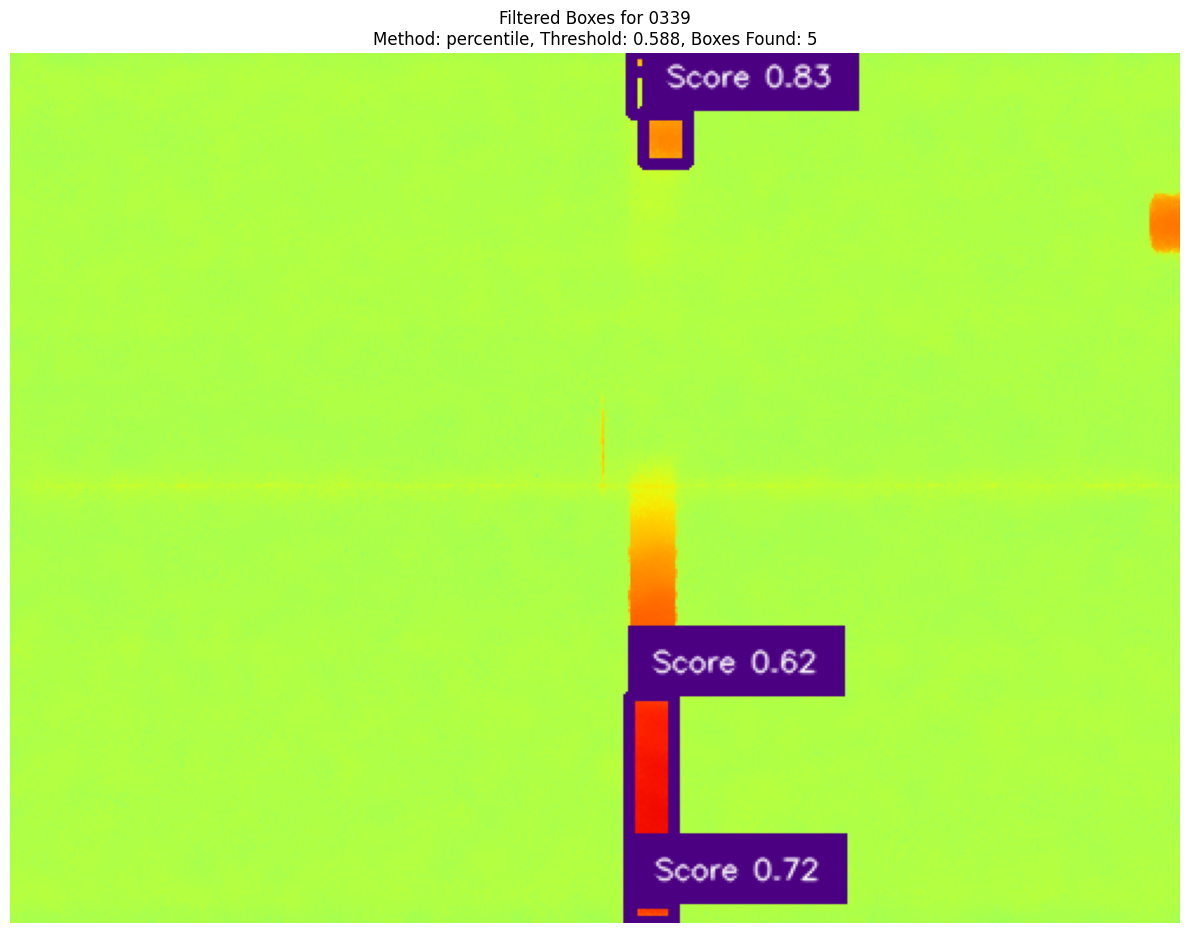

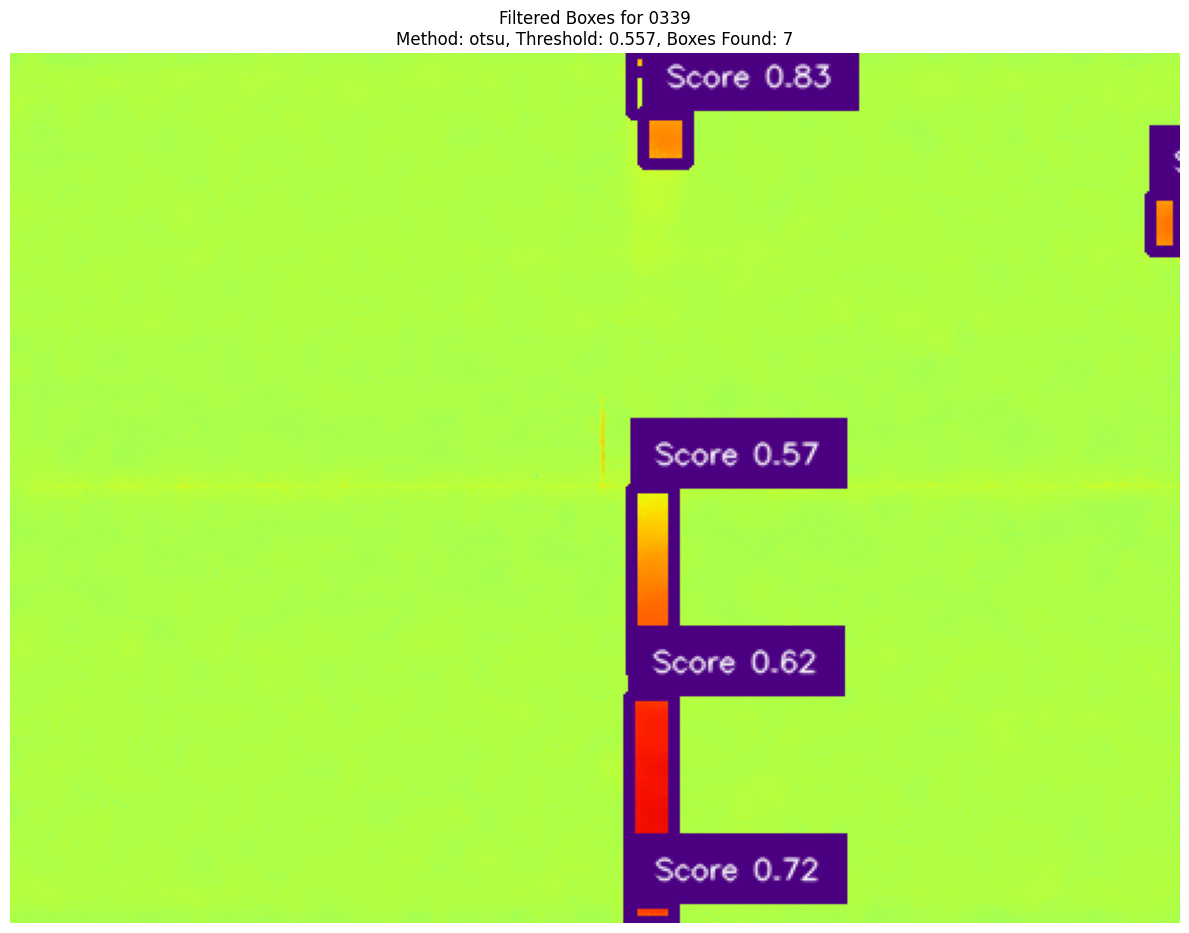

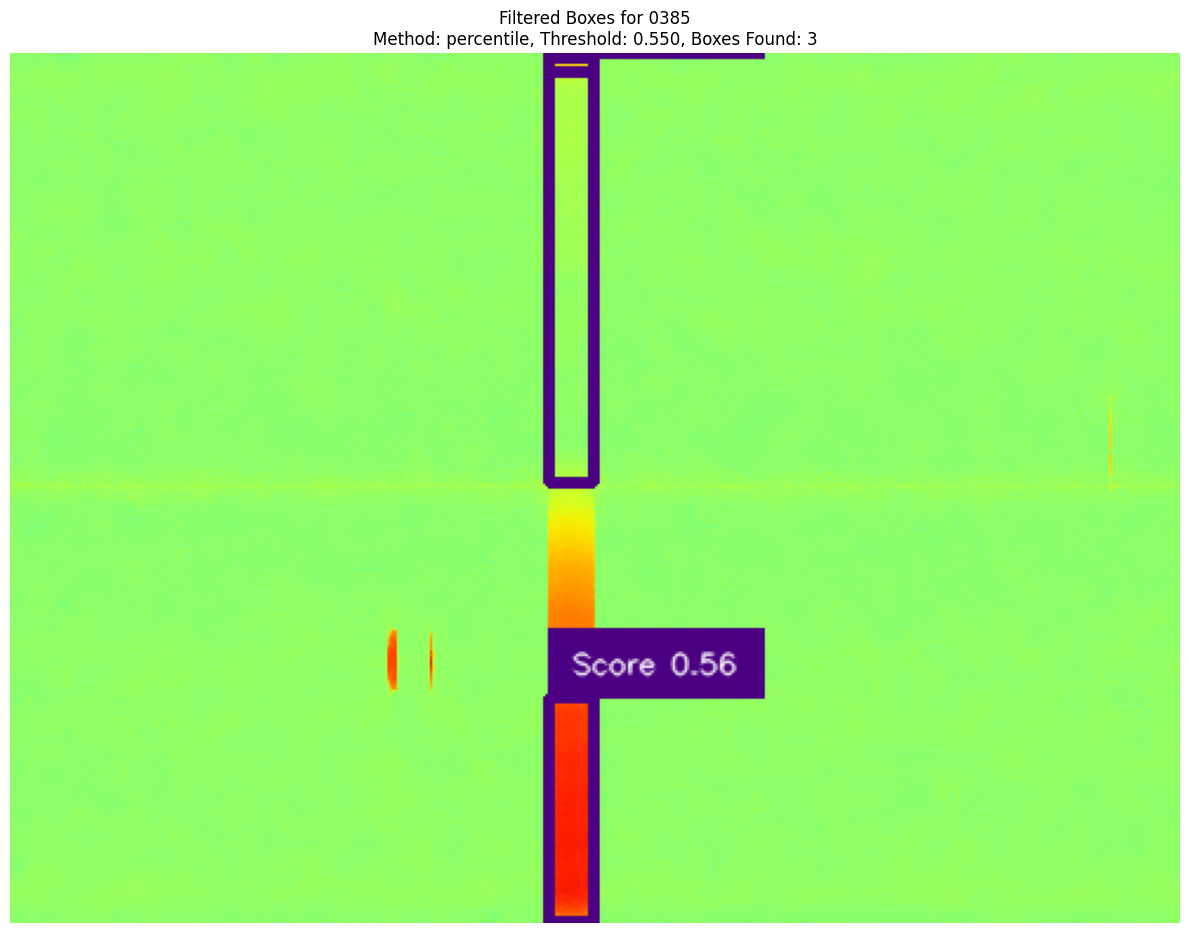

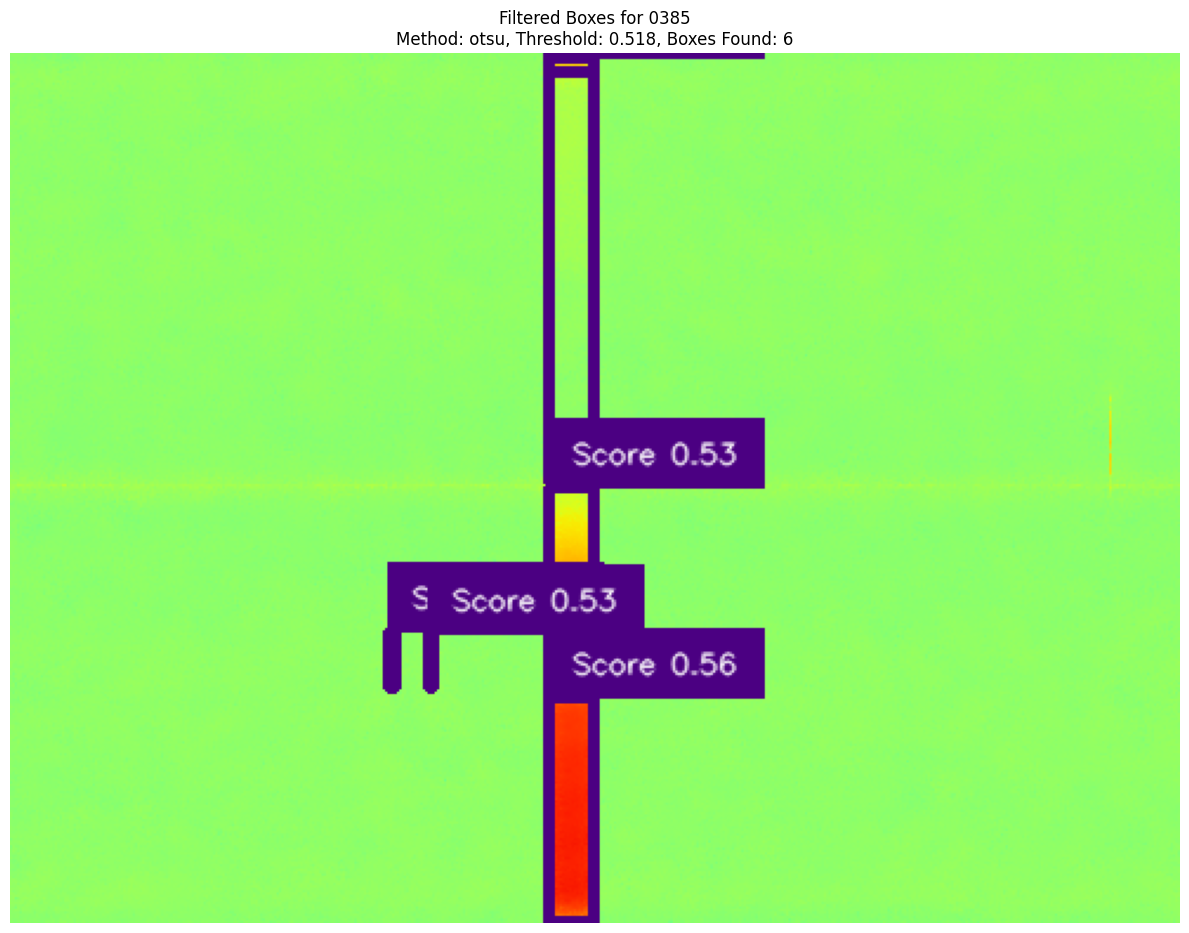

In [17]:
# Cell 7: Visualize the Results (Indigo Color, Matplotlib Display)

# --- 1. Define Custom Color (Indigo) ---
# Hex code for Indigo is #4B0082
indigo_color = sv.Color.from_hex('#4B0082')

# --- 2. Create Annotators with Specific Style ---
# Box Annotator: Thicker borders, fixed Indigo color
box_annotator = sv.BoxAnnotator(
    thickness=3,       # Thicker border
    color=indigo_color, # Force Indigo color
    color_lookup=sv.ColorLookup.INDEX
)

# Label Annotator: Indigo background for text
label_annotator = sv.LabelAnnotator(
    text_thickness=1,
    text_scale=0.4,
    text_position=sv.Position.TOP_LEFT,
    color=indigo_color, # Force Indigo color
    color_lookup=sv.ColorLookup.INDEX
)

def visualize_filtered_results(spectrogram_id, image_dir, results_dir, threshold_method):
    """Loads an image and its JSON results, and overlays boxes using Supervision."""

    image_path = os.path.join(image_dir, f"{spectrogram_id}.png")
    json_path = os.path.join(results_dir, threshold_method, f"{spectrogram_id}_filtered.json")

    if not os.path.exists(json_path):
        print(f"JSON file for {spectrogram_id} (method: {threshold_method}) not found.")
        return

    image_bgr = cv2.imread(image_path)
    denoised_image = cv2.bilateralFilter(image_bgr, d=15, sigmaColor=75, sigmaSpace=75)
    image_bgr = denoised_image.copy()
    with open(json_path, 'r') as f:
        data = json.load(f)

    bboxes_xywh = np.array([box['bounding_box'] for box in data['boxes']])

    if len(bboxes_xywh) == 0:
        detections = sv.Detections.empty()
    else:
        scores = np.array([box['confidence_score'] for box in data['boxes']])

        # Convert XYWH to XYXY
        bboxes_xyxy = bboxes_xywh.copy()
        bboxes_xyxy[:, 2] = bboxes_xyxy[:, 0] + bboxes_xyxy[:, 2]
        bboxes_xyxy[:, 3] = bboxes_xyxy[:, 1] + bboxes_xyxy[:, 3]

        detections = sv.Detections(
            xyxy=bboxes_xyxy,
            confidence=scores
        )

    labels = [f"Score {confidence:.2f}" for confidence in detections.confidence]

    # Annotate
    annotated_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections)
    annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections, labels=labels)

    # --- 3. Display using Matplotlib (Replaces sv.plot_image) ---
    # Convert BGR to RGB for matplotlib
    plt_image = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(12, 12))
    plt.imshow(plt_image)

    title = (f"Filtered Boxes for {spectrogram_id}\n"
             f"Method: {data['metadata']['threshold_method']}, "
             f"Threshold: {data['metadata']['threshold_value']:.3f}, "
             f"Boxes Found: {data['signal_boxes_found']}")

    plt.title(title)
    plt.axis('off')
    plt.tight_layout()  # Adjust layout to avoid clipping
    plt.show()

# --- Visualize the results from all experiments ---
print("\n\n===== VISUALIZING RESULTS =====")
experiments = ['percentile',  'otsu']
first_exp_dir = os.path.join('filtered_results', experiments[0])

if os.path.exists(first_exp_dir):
    processed_files = sorted([
        f.replace('_filtered.json', '')
        for f in os.listdir(first_exp_dir)
        if f.endswith('_filtered.json')
    ])

    if not processed_files:
        print(f"No processed JSON files found in {first_exp_dir}.")

    for spectrogram_id in processed_files:
        for method in experiments:
            visualize_filtered_results(spectrogram_id, 'image_captures', 'filtered_results', method)
else:
    print(f"No results found for experiment '{experiments[0]}'. Please run the processing cell first.")